# The sample guessing game
In this game, we analyze 6 files, `sample[0-6].root` that are each a small 500k event sample of a CMS NanoAOD dataset.  All generator-level branches have been removed.  Your task is to figure out which file came from which dataset.  To make it a bit easier, here are the 6 possible datasets:

   * `DY2JetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8`, producing $Z(\to \ell\ell)+2j$ events via QCD processes;
   * `ST_t-channel_4f_leptonDecays_TuneCP5_PSweights_13TeV-amcatnlo-pythia8`, producing single-top events through W boson exchange between a light and $b$ quark, where the $W$ boson from the top decay itself decays leptonically;
   * `GluGluHToWWTo2L2Nu_M125_13TeV_powheg2_JHUGenV714_pythia8`, producing Higgs boson events through gluon fusion, where the Higgs boson decays via $H\to WW^{*}\to 2\ell2\nu$;
   * `GluGluHToZZTo2L2Q_M125_13TeV_powheg2_JHUGenV7011_pythia8`, producing Higgs boson events through gluon fusion, where the Higgs boson decays via $H\to ZZ^{*}\to 2\ell2q$;
   * `TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8`, producing di-top events, where both $W$ bosons from the top quark decays must decay leptonically; and
   * `WWTo2L2Nu_NNPDF31_TuneCP5_13TeV-powheg-pythia8`, producing WW diboson events, where both W bosons decay leptonically $W\to \ell\nu$.
   
In all cases, the lepton can be any flavor, $\ell\in\{e,\mu,\tau\}$.  All 6 datasets were produced with the `RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21` conditions tag.

In [1]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

import hist
from coffea.nanoevents import NanoEventsFactory

In [2]:
prefix = 'root://xcache//store/user/ncsmith/samplegame/'
samples = [
    NanoEventsFactory.from_root(prefix + "sample%d.root" % i).events()
    for i in range(6)
]

Here's an example of plotting all 6 samples together for one variable (here `Jet.pt`)
Let your physics intuition guide you, and good luck!

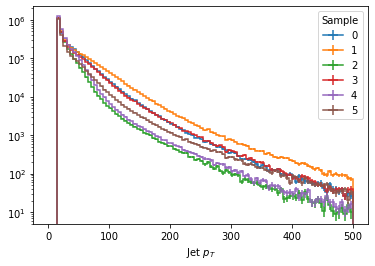

In [3]:
h = (
    hist.Hist.new
    .IntCat(range(6), label="Sample")
    .Reg(100, 0, 500, label="Jet $p_T$")
    .Double()
)
for i, sample in enumerate(samples):
    h.fill(i, ak.flatten(sample.Jet.pt))

fig, ax = plt.subplots()
h.plot1d(ax=ax)
ax.set_yscale("log")
ax.legend(title="Sample")